### Load libraries


In [2]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import phase_portraits as pp
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import seaborn as sns
import pandas as pd

%matplotlib inline

## Parameter estimation

We will use the pendulum as the example problem. 

Remember that the non-linear pendulum is described by 
$$
\begin{array}{rcl}
\dot{x} &=& \ y \\
\dot{y} &=& - \omega \sin (x) - \varphi  y
\end{array}
$$
where $\omega=\sqrt{g/l}$ is the frequency and  $\varphi=b/m$ is a friction parameter. 

Let's say we're measuring a pendulum. How do we determine the friction parameter?

Do the following:
1. Create syntethic data, add noise. 
2. Define an objective function
3. Use scipy.optimize.minimum to estimate the parameters. 

### Synthetics data

In [17]:
# Define the system of ODEs
def rhs_pendulum(t, xy, omega,phi=0 ): 
    x,y=xy
    dx = y
    dy = - omega * np.sin(x) - phi*y 
    return [dx, dy]


In [ ]:
L= 1.5
omega= np.sqrt(9.81/L)
phi = 0.2  # 
t_num=29
t_data = np.linspace(0, 10, t_num)
y0=[2.,0]
tmp=sc.integrate.solve_ivp(rhs_pendulum,t_span=(0.,t_data[-1]),y0=y0,t_eval=t_data,args=[omega,phi])
data=tmp.y[0] #*np.random.uniform(0.8,1.2)


## A short digression, uncertainties in length or initial conditions

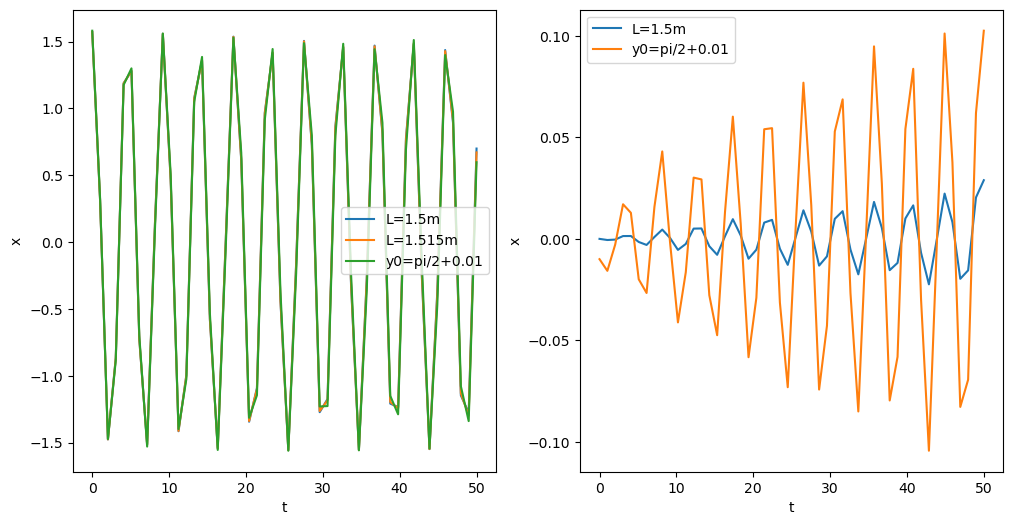

In [103]:
L= 1.5
omega= np.sqrt(9.81/L)
L1=L*1.001
omega1= np.sqrt(9.81/L1)
phi = 0 # 
t_num=50
t_data = np.linspace(0, 50, t_num)
y0=[np.pi/2,0]
y1=[np.pi/2+0.01,0.01]
tmp=sc.integrate.solve_ivp(rhs_pendulum,t_span=(0.,t_data[-1]),y0=y0,t_eval=t_data,args=[omega,phi])
tmp1=sc.integrate.solve_ivp(rhs_pendulum,t_span=(0.,t_data[-1]),y0=y0,t_eval=t_data,args=[omega1,phi])
tmp2=sc.integrate.solve_ivp(rhs_pendulum,t_span=(0.,t_data[-1]),y0=y1,t_eval=t_data,args=[omega,phi])
data=tmp.y[0] #

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(tmp.t, tmp.y[0], label='L=1.5m')
ax[0].plot(tmp1.t, tmp1.y[0], label='L=1.515m')
ax[0].plot(tmp2.t, tmp2.y[0], label='y0=pi/2+0.01')
ax[0].set_xlabel('t')
ax[0].set_ylabel('x')
ax[0].legend()

ax[1].plot(tmp.t, tmp.y[0]-tmp1.y[0], label='L=1.5m')
ax[1].plot(tmp1.t, tmp.y[0]-tmp2.y[0], label='y0=pi/2+0.01')
ax[1].set_xlabel('t')
ax[1].set_ylabel('x')
ax[1].legend()
plt.show()

## Parameter estimation

In [148]:
L= 1.
omega= np.sqrt(9.81/L)
phi = 0 # 
t_num=150
t_data = np.linspace(0, 50, t_num)
y0=[np.pi/2,0]

tmp=sc.integrate.solve_ivp(rhs_pendulum,t_span=(0.,t_data[-1]),y0=y0,t_eval=t_data,args=[omega,phi])
# Add random noise to the data
data=tmp.y[0] #*np.random.uniform(0.8,1.2)
noise_level = 0.02
observations = data * np.random.normal(1, noise_level, size=data.shape)
print(observations)

[ 1.57338046  1.36239327  0.89584429  0.10301886 -0.70415733 -1.32873424
 -1.52699051 -1.45777687 -1.06907756 -0.30062277  0.53052301  1.18446234
  1.44561374  1.5385315   1.13860578  0.46241478 -0.33368001 -1.06950555
 -1.48433365 -1.5205131  -1.29002831 -0.66590753  0.14945968  0.90615517
  1.47281198  1.50401372  1.37961069  0.81980834  0.05248169 -0.74877644
 -1.32634922 -1.59327898 -1.44954928 -0.98074371 -0.24446864  0.57746745
  1.21472702  1.57375662  1.48836396  1.10329202  0.43176669 -0.39524843
 -1.11652358 -1.44981863 -1.58270293 -1.25539662 -0.63582523  0.19368263
  0.93956523  1.46422405  1.52382701  1.33614077  0.78924788 -0.00851784
 -0.79263131 -1.33286454 -1.59112519 -1.47062636 -0.93091316 -0.17819611
  0.62576869  1.27986972  1.51127299  1.50193413  1.05764731  0.36957479
 -0.45897247 -1.15776051 -1.44662398 -1.54264822 -1.20929694 -0.52435324
  0.27223612  1.02804932  1.44057889  1.57072264  1.34335679  0.70718862
 -0.09428405 -0.89524309 -1.3554963  -1.5207007  -1

Here we add some noise to the observations

Lets have a look at the results

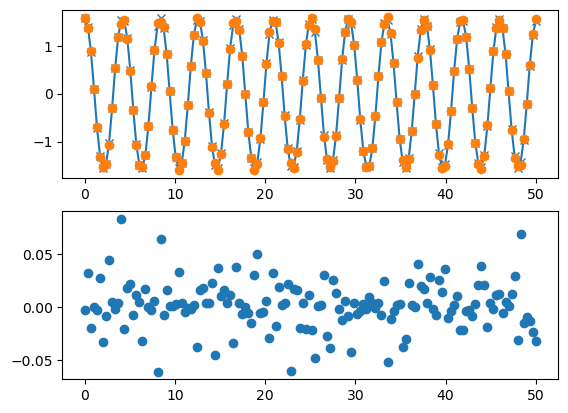

In [149]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(t_data,data,'-x',t_data,observations,'o')
axs[1].plot(t_data,data-observations,'o')

### The objective function

So now we have a set of observations, with noise. Lets estimate the parameters based on this. 

First we need an objective function.


In [150]:

def objective(params,t,y):
    omega, phi= params
    t_end=t[-1]
    y0=[y[0],0]
    tmp=sc.integrate.solve_ivp(rhs_pendulum,t_span=(0.,t_end),y0=y0,t_eval=t,args=[omega,phi])
    
    return np.sum((y - tmp.y[0]) ** 2)/len(y)



In [151]:
# Lets check the objective function
omega_guess=1
phi_guess=phi
obj_tmp=objective([omega_guess,phi_guess],t_data,observations)
obj_tmp

2.455921121527608

Lets call the scipy function minimize. 

In [152]:
# Ensure t_data and observations have the same length

omega_guess=1
phi_guess=phi
result = sc.optimize.minimize(objective, [omega_guess, phi_guess], args=(t_data, observations))

# Calculate the error estimates
omega_error = np.sqrt(result.hess_inv[0, 0])
phi_error = np.sqrt(result.hess_inv[1, 1])


omega_calc = result.x[0]
phi_calc = result.x[1]
print('Omega given:', omega)
print('Omega estimated:', omega_calc)
print('Omega error estimate:', omega_error)
print('Phi given:', phi)
print('Phi estimated:', phi_calc)

print('Phi error estimate:', phi_error)

Omega given: 3.132091952673165
Omega estimated: 2.94607692192977
Omega error estimate: 6.24997549507413
Phi given: 0
Phi estimated: 0.06941357212810442
Phi error estimate: 6.294714148598473


1. Try to increase the noise, how good are the estimates? 
2. Increase the number of observations, will the estimates be better? 
3. Can you make the length of the pendulum as the unknown parameter? 


## Probability distributions in Python

There are many distributions and Python has many statistical libraries that can provide sampling from them. We will use the ones provided by scipy, see documentation on [https://docs.scipy.org/doc/scipy/reference/stats.html](https://docs.scipy.org/doc/scipy/reference/stats.html) 



### The uniform distribution


In [153]:
n = 1000
start = 0
width = 1
x_uniform = sc.stats.uniform.rvs(size=n, loc = start, scale=width)
print('Mean value: ',x_uniform.mean(),'Standard deviation: ',x_uniform.std())

Mean value:  0.49195494872583334 Standard deviation:  0.28756843116040737


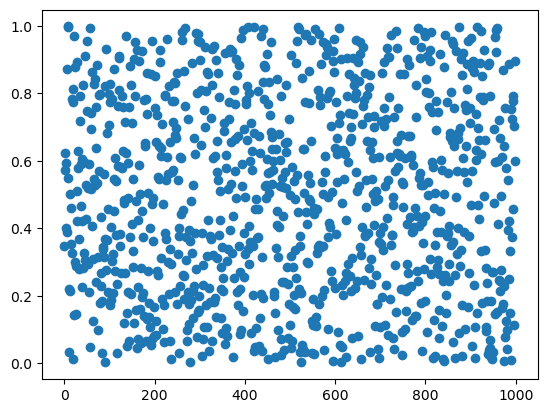

In [154]:
plt.plot(x_uniform,'o')



Using the Seaborn routine


[Text(0.5, 0, 'Normal Distribution'), Text(0, 0.5, 'Frequency')]

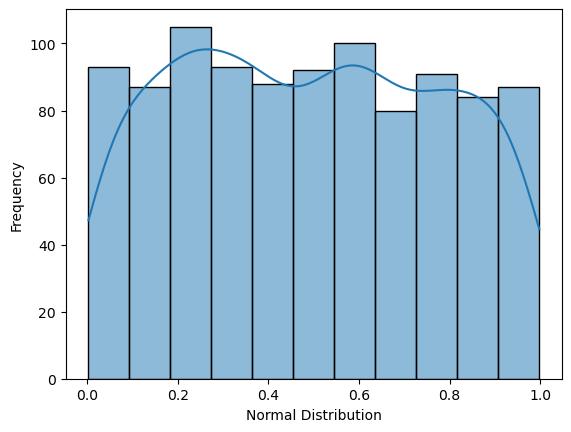

In [155]:
ax = sns.histplot(x_uniform,
                  kde=True,)
ax.set(xlabel='Normal Distribution', ylabel='Frequency')

### The normal distribution

$$
 p(x)= \displaystyle\frac{1}{2\pi\sigma}e^{-\frac{(x-\mu)^2}{\sigma^2}}
$$

where $\mu$ is the mean and $\sigma$ is the standard deviation. 

In [156]:
n=10000
loc=2
scale = 4
x_norm=sc.stats.norm.rvs(size=n,loc=loc,scale=scale)
print('Mean: ', x_norm.mean(), ' Standard deviation: ', x_norm.std())

Mean:  1.9079865603114856  Standard deviation:  3.991680537803115


[Text(0.5, 0, 'Normal Distribution'), Text(0, 0.5, 'Frequency')]

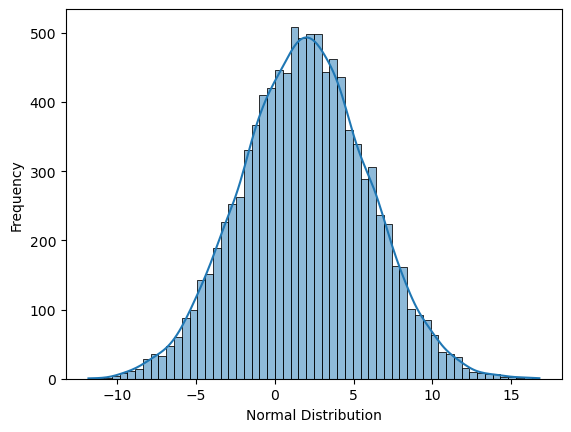

In [157]:
ax = sns.histplot(x_norm,
                  kde=True,)
ax.set(xlabel='Normal Distribution', ylabel='Frequency')

There are many other probability distributions. Check [https://docs.scipy.org/doc/scipy/reference/stats.html](https://docs.scipy.org/doc/scipy/reference/stats.html)

## The pendulum (revisited)

Lets see how uncertainties in parameters influence on the model predictions. 

In [158]:

# Define the system of ODEs
def rhs_pendulum(t, xy, omega,phi=0 ): 
    x,y=xy
    dx = y
    dy = - omega * np.sin(x) - phi*y 
    return [dx, dy]


Lets assume that we have an uncertainty in our parameters.

In [159]:


# Set parameters
length_mean = 1.0
length_std = 0.1
g=9.18


#Draw and calculate frequency
l_num=1000

l_norm=np.random.normal(loc=length_mean,scale=length_std, size=l_num)
l_unif=np.random.uniform(length_mean-2*length_std,length_mean+2*length_std,l_num)
omega_norm=np.sqrt(l_norm/g)
omega_unif=np.sqrt(l_unif/g)

#Create the time vector
t_end=40.
t_num=41
t = np.linspace(0, t_end, t_num)

# Set initial conditions
y0=[1,0]
x_norm=np.zeros((l_num,t_num))
y_norm=np.zeros((l_num,t_num))

x_unif=np.zeros((l_num,t_num))
y_unif=np.zeros((l_num,t_num))

for ii in np.arange(len(omega_norm)):
    tmp=sc.integrate.solve_ivp(rhs_pendulum,t_span=(0.,t_end),y0=y0,t_eval=t,args=[omega_norm[ii]])
    x_norm[ii,:]=tmp.y[0]
    y_norm[ii,:]=tmp.y[1]
    
for ii in np.arange(len(omega_unif)):
    tmp=sc.integrate.solve_ivp(rhs_pendulum,t_span=(0.,t_end),y0=y0,t_eval=t,args=[omega_unif[ii]])
    x_unif[ii,:]=tmp.y[0]
    y_unif[ii,:]=tmp.y[1]



    



In [160]:
x=x_norm
y=y_norm

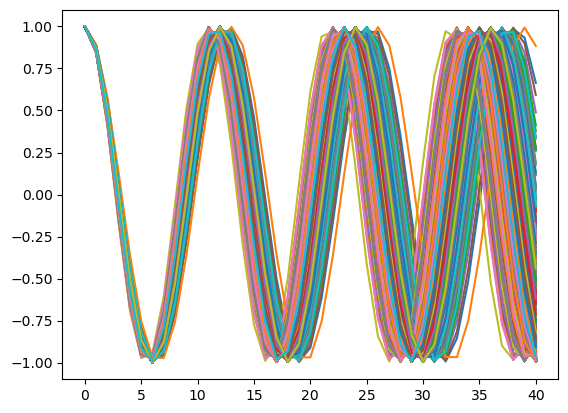

In [161]:
plt.plot(x.T)
plt.show()

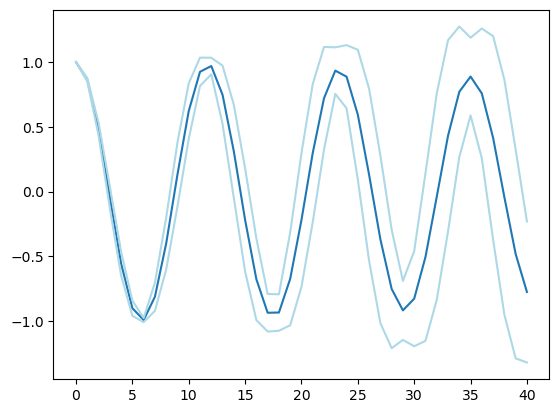

In [162]:
plt.plot(x.mean(axis=0))
plt.plot(x.mean(axis=0)+2*x.std(axis=0),color='lightblue')
plt.plot(x.mean(axis=0)-2*x.std(axis=0),color='lightblue')
plt.show()

1. Can you make a loop that see how the mean and standard deviation estimate changes with the number of samples. 
2. See how this changes when you increase the uncertainties. 
3. Can involve the friction term?

Here is a go at no 1. 

Create first a function that run the ensemble. 

Since we are only interested in the mean value and the standard deviation, $\sigma$, and to save memory we're using the following. 
$$
\begin{array}{rl}
 \sigma^2 =& \frac{1}{n}\sum_i ({\overline{x}-x_i})^2=  \frac{1}{n}\sum_i (\overline{x}^2-2\overline{x} x_i + x_i^2)\\ 
 & \\
= & \frac{1}{n}\sum_i \overline{x}^2-2\overline{x}\frac{1}{n}\sum_i x_i + \frac{1}{n}\sum_ix_i^2\\
& \\
= & \overline{x_i^2}-\overline{x}^2
\end{array}
$$



In [163]:

def run_ensemble(l_num=1000,length_mean = 1.0, length_std = 0.1, t_end=40., y0=[1,0],t_num=41, g=9.18,dist=0):
# A function that runs the ensembles for the pendulum
# Input: l_num, the number of samples in the ensemble
#       length_mean, the mean length of the pendulum
#       length_std, standard deviation of the length of the pendulum
#       g, is the gravitational constant
#       dist, the distribution function to use
# Output: t time when we do the statistics. 
#         x_mean, the mean values
#         Standard deviations.             
    if (dist == 0):
        l=np.random.normal(loc=length_mean,scale=length_std, size=l_num)
    elif(dist == 1):
        l=np.random.uniform(length_mean-2*length_std,length_mean+2*length_std,l_num)
    else:
        print('Not implemented yet, distr:', dist)
    

    omega=np.sqrt(g/l)


#Create the time vector, this should be an input. 
    
    t = np.linspace(0, t_end, t_num)



# Store the results. 
    x=t*0
    x2=t*0

    
# Here we loop through the samples. 

    for ii in np.arange(len(omega)):
        tmp=sc.integrate.solve_ivp(rhs_pendulum,t_span=(0.,t_end),y0=y0,t_eval=t,args=[omega[ii]])
        #Sum the x and the x squared. 
        x=x+tmp.y[0]
        x2=x2+tmp.y[0]**2

# and do the statistics
    x=x/l_num
    x2=np.sqrt((x2/l_num)-x**2)
    return [t,x,x2]
    




    



In [164]:
# Create an array of samples to run
l_nums=np.array([10,50,100,200, 300, 400, 500,800,1000,1500,2000,3000, 3500, 4000, 4500, 5000])
l_nums=np.array([2,5,10,50,100,150])
# Create arrays, note only doing statistics at the end time point. 
t_num=41
# Set initial conditions, could also be an input. 
y0=[1,0]

x_mean=np.zeros((len(l_nums),t_num))
x_std=np.zeros((len(l_nums),t_num))

# Calculate a solution with the mean length
length_mean = 1.0
length_std = 0.2

g=9.81
t_end=15
t = np.linspace(0, t_end, t_num)
omega=np.sqrt(g/length_mean)
sol=sc.integrate.solve_ivp(rhs_pendulum,t_span=(0.,t_end),y0=y0,t_eval=t,args=[omega])

for jj in np.arange(len(l_nums)):
    print(jj, l_nums[jj])
    tmp_t,tmp_mean,tmp_std=run_ensemble(l_num=l_nums[jj],length_mean = length_mean, length_std = 0.1,t_end=t_end, g=9.18,dist=0)
    x_mean[jj,:]=tmp_mean
    x_std[jj,:]=tmp_std


0 2
1 5
2 10
3 50
4 100
5 150


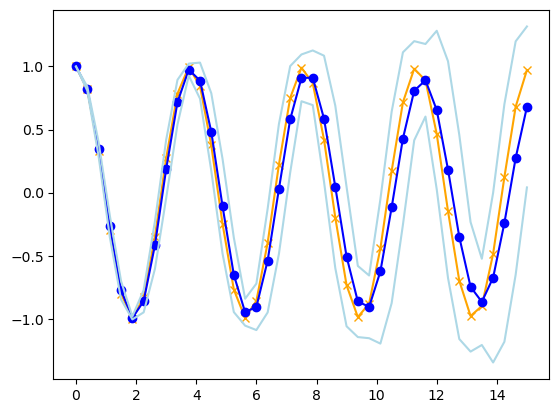

In [165]:
ii=-1
plt.plot(sol.t,sol.y[0],'x-',color='orange')
plt.plot(sol.t,x_mean[ii,:],'o-',color='blue')
plt.plot(sol.t,x_mean[ii,:]+2*x_std[ii,:],'-',color='lightblue')
plt.plot(sol.t,x_mean[ii,:]-2*x_std[ii,:],'-',color='lightblue')


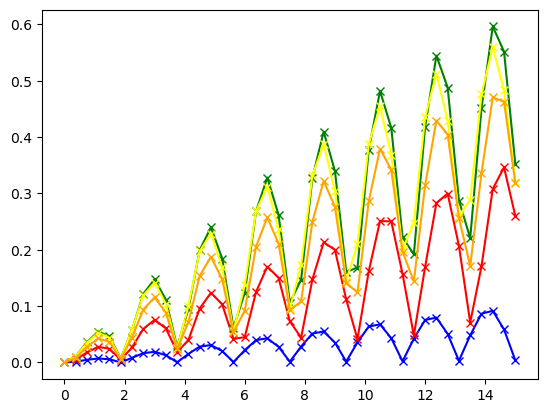

In [166]:

plt.plot(sol.t,x_std[0,:],'x-',color='blue')

plt.plot(sol.t,x_std[1,:],'x-',color='red')
plt.plot(sol.t,x_std[2,:],'x-',color='green')
plt.plot(sol.t,x_std[3,:],'x-',color='yellow')
plt.plot(sol.t,x_std[-1,:],'x-',color='orange')

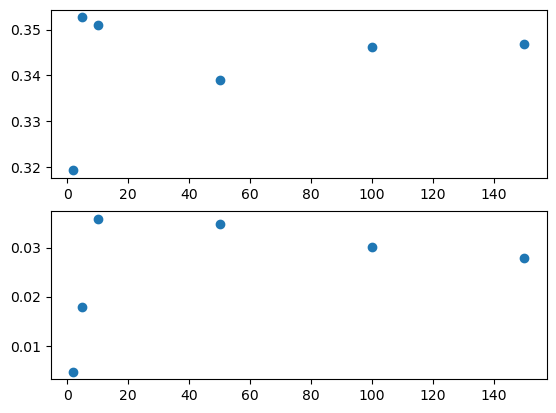

In [167]:
fig,axs = plt.subplots(2,1)
axs[0].plot(l_nums,x_mean[:,2],'o')
axs[1].plot(l_nums,x_std[:,2],'o')

## Libraries to look into:
- Pandas [https://pandas.pydata.org/docs/index.html](https://pandas.pydata.org/docs/index.html)
- Seaborn [https://seaborn.pydata.org](https://seaborn.pydata.org) 
